# TRAINING A CLASSIFIER: 분류기 학습 [link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
---------------------------
이 전까지가 뉴럴 네트워크를 어떻게 정의하고 loss를 계산하고 네트워크의 weight들을 어떻게 업데이트를 하는지에 대한거 였습니다

아래부터는 실제 데이터를 활용해 어떻게 학습하는지에 대해 알아봅니다

일반적으로 이미지, 텍스트, 오디오, 비디오 데이터를 다뤄야 할때 데이터를 numpy array로 사용하는 기본적인 python package를 사용할 수 있으며 이를 `torch.*Tensor`로 변환할 수도 있습니다
* 이미지는 Pillow, OpenCV 패키지들이 유용합니다
* 오디오는 scipy, librosa 패키지가 유용합니다
* text는 단순 Python, Cython이나 NLTK와 SpaCy들이 유용합니다

특별히 vision에는(pytorch에는 torchvision이라는 패키지가 있습니다) Imagenet, CIFAR10, MNIST 등과 같은 공용적인 데이터들을 위한 data loader와 `torchvision.datasets`과 `torch.utils.data.DataLoader`라는 이미지 data transformer들도 있습니다.

`torchvision`은 방대한 편리함을 제공하며 템플릿코드 작성하는걸 방지해줍니다

이 튜토리얼에서 CIFAR10 dataset을 사용할겁니다. 이 dataset은 airplane, automobile, bird, cat, deer, dog, frog, horse, shipt, truck과 같은 클래스들이 있습니다. 이 CIFAR-10 이미지들의 사이즈는 3x32x32입니다. 즉, 32x32 픽셀에 3 채널 칼라 이미지들인겁니다



<img src="images/cifar10.png" alt="Drawing" style="width: 500px;"/>

## 이미지 분류기 학습

아래 순서로 진행할겁니다. 많은 모델들이 아래 절차대로 진행이되니 순서를 익히는것이 좋습니다

1. `torchvision`을 활용하여 CIFAR10 data를 train용과 test용으로 불러오고 정규화 합니다
2. Convolutional Neural Network를 정의합니다
3. loss function을 정의합니다
4. 학습 데이터에서 네트워크를 학습합니다
5. 테스트 데이터에서 네트워크를 테스트합니다

## 1. CIFAR10 이미지를 불러오고 정규화하기
`tochvision`을 사용하면, CIFAR10을 불러오는건 매우 쉽습니다

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋들의 출력은 0과 1의 범위를 갖는 PILImage 이미지들입니다. 이제 이들을 -1에서 1의 범위를 갖는 정규화된 텐서들로 변형합니다

※만약 Windows 환경에서 BrokenPipeError가 발생한다면, torch.utils.data.DataLoader()의 num_worker를 0으로 설정하면 동작할 수도 있습니다

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


아래는 학습 이미지들의 일부입니다

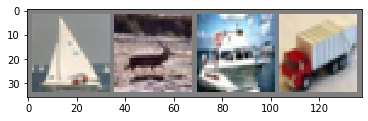

 ship  deer  ship truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Convolutional Neural Network를 정의
이전에 진행한 뉴럴 네트워크 섹션에서 뉴럴네트워크 코드를 복사합니다. 그리고 원래 1채널 이미지들로 정의된 이미지들을 3채널로 수정합니다

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Loss function과 optimizer 정의
크로스 엔트로피 loss와 momentum을 가지고 있는 SGD를 사용합니다

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. 네트워크 학습
단순히 iterator를 loop하고 input들을 네트워크에 feed하고 최적화를 진행하면 됩니다

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.184
[1,  4000] loss: 1.881
[1,  6000] loss: 1.705
[1,  8000] loss: 1.621
[1, 10000] loss: 1.559
[1, 12000] loss: 1.512
[2,  2000] loss: 1.421
[2,  4000] loss: 1.408
[2,  6000] loss: 1.382
[2,  8000] loss: 1.332
[2, 10000] loss: 1.329
[2, 12000] loss: 1.318
Finished Training


학습된 모델을 저장합니다

In [8]:
PATH = './model/cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorch 모델 저장에 대한 자세한 내용은 [여기](https://pytorch.org/docs/stable/notes/serialization.html)에서도 참고 가능합니다

## test data에서 네트워크 테스트하기
방금까지 학습 데이터셋을 두번 반복하여 네트워크를 학습했습니다. 그러나 우리는 네트워크가 잘배웠는지 확인해야합니다

네트워크 출력을 통해 클래스 레이블(예를들어 이미지 이름)을 예측하게하여 정답과 비교하여 확인할겁니다. 만약 예측이 맞다면, 정답 리스트에 이를 추가할겁니다

먼저, 이해하기 쉽도록 테스트 셋에서 이미지를 불러와서 확인해봅시다

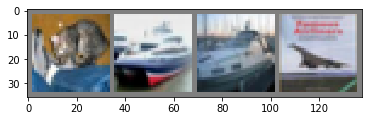

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

다음으로 저장했던 모델을 다시 로딩합니다 (사실 모델을 저장하고 다시 불러오는 작업은 여기에서 불필요합니다. 단지 어떻게 하는지 설명을 위한 겁니다)

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


이제 전체 데이터셋에 대하여 네트워크 성능이 어떤지 확인해봅니다

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


위 결과는 10% 정확도보다 더 나아보입니다(10개의 레이블에서 한개를 랜덤하게 꺼낼 확률). 신경망이 뭔가 배운다는걸 알수 있습니다.
그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못하는지 알아봅니다

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 67 %
Accuracy of  bird : 47 %
Accuracy of   cat : 23 %
Accuracy of  deer : 22 %
Accuracy of   dog : 57 %
Accuracy of  frog : 76 %
Accuracy of horse : 49 %
Accuracy of  ship : 66 %
Accuracy of truck : 69 %


## GPU에서 학습하기
Tensor를 GPU로 이동했던 것처럼, 신경망 또한 GPU로 옮길 수 있습니다.
먼저 첫번째 CUDA 장치를 사용하도록 설정합니다

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device) # CUDA 기기가 존재한다면, CUDA를 출력합니다:

cuda:0


이 섹션의 나머지 부분에서는 `device`가 CUDA라고 가정합니다.
그리고 아래 메소드는 재귀적으로 모든 모듈의 파라미터와 버퍼를 CUDA tensor로 변경합니다

In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

이렇게 되면 학습이 진행되는 모든 step에서도 input과 target들을 GPU로 변환해야한다는 것을 잊으면 안됩니다

In [18]:
inputs, labels = data[0].to(device), data[1].to(device)

CPU와 비교했을 때 어마어마한 속도 차이가 나지 않는 것은 왜 그럴까요? 그 이유는 바로 신경망이 너무 작기 때문입니다.

이 후 연습용으로 추천: 신경망의 크기를 키워보고, 얼마나 빨라지는지 확인해보세요. (첫번째 `nn.Conv2d` 의 2번째 인자와 두번째 `nn.Conv2d` 의 1번째 인자는 같은 숫자여야 합니다.)

## 여러개의 GPU에서 학습하기
멀티 GPU로 속도를 더 올리는 방법은 [Optional: Data Parallelism](https://tutorials.pytorch.kr/beginner/blitz/data_parallel_tutorial.html) 을 참고바랍니다.